# Synthetic features and outliers

### Learning Objective:
* Create a synthetic feature that is the ration of two other feature
* Use this new feature as input to a linear regression model
* Improve the effectiveness of the model by identifying and clipping outliers out of the input data.

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

Loading the dataset

In [2]:
california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)
)

california_housing_dataframe["median_house_value"] /= 1000.0

california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5374,-118.2,34.0,17.0,3361.0,925.0,3264.0,914.0,2.3,145.6
15975,-122.4,37.8,52.0,3257.0,735.0,1045.0,620.0,4.6,500.0
12520,-121.6,38.0,17.0,2549.0,596.0,1169.0,500.0,3.7,209.4
15806,-122.4,37.7,38.0,1754.0,382.0,928.0,354.0,4.1,270.8
10269,-120.0,38.9,22.0,3080.0,610.0,1045.0,425.0,3.0,126.1
...,...,...,...,...,...,...,...,...,...
12818,-121.8,37.3,15.0,1794.0,366.0,1533.0,371.0,5.8,209.9
16558,-122.7,38.4,32.0,2826.0,627.0,1767.0,628.0,3.1,141.4
13061,-121.9,37.4,16.0,2655.0,487.0,1862.0,448.0,6.1,246.8
783,-117.1,32.6,34.0,4325.0,1015.0,2609.0,979.0,2.8,128.3


#### Setting up the input function

In [3]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    Train the LinearRegresssor model of one feature.
    
    Args:
        features: pandas Dataframe of features
        targets: pandas Dataframe of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False. Whether to shuffle the data.
        num_epochs: Number of epochs should data be repeated. If set to None, it will repeat infinitely.
    Returns:
        Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into dict of np arrays.
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets)) 
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [4]:
def train_model_new(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
  return calibration_data

## Task 1: Synthetic Feature

Both total_rooms and populations features count totals for a given city block.

But what if one city block is densely populated than the others? We can explore density related to median house value by creating a synthetic feature that's ratio of total_rooms and population.

In the below cell I'm gonna create a new feature called rooms_per_person, and use it as the input feature to train_model().

Training model...
RMSE (on training data):
  period 00 : 235.00
  period 01 : 232.48
  period 02 : 229.97
  period 03 : 227.46
  period 04 : 224.97
  period 05 : 222.50
  period 06 : 220.04
  period 07 : 217.60
  period 08 : 215.17
  period 09 : 212.85
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,27.6,207.3
std,13.0,116.0
min,5.8,15.0
25%,22.5,119.4
50%,27.1,180.4
75%,31.1,265.0
max,618.9,500.0


Final RMSE (on training data): 212.85


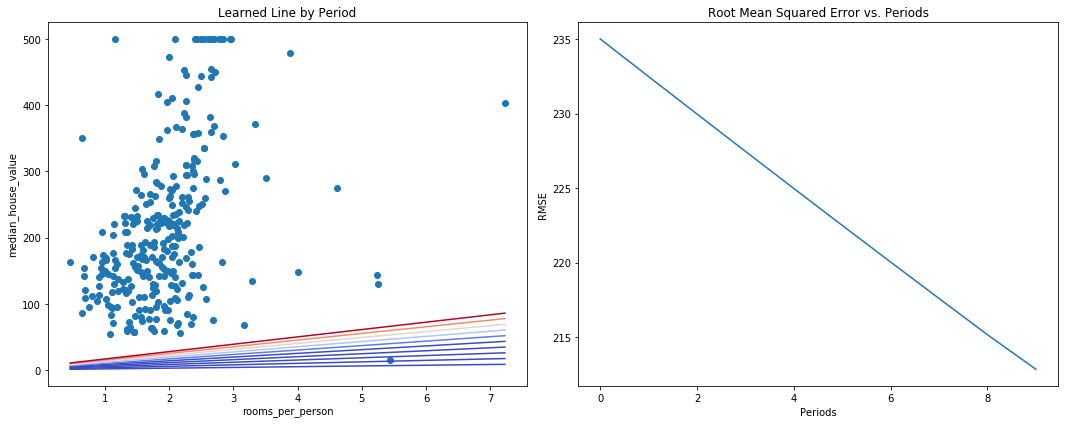

In [5]:
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]

calibration_data = train_model_new(
    learning_rate = 0.005,
    steps = 500,
    batch_size = 5,
    input_feature = "rooms_per_person"
)

## Identify Outliers

We can visualize the performance of our model by creating a scatter plot of predictions vs target values. Ideally, this would lie on the perfectly corrreated diagonal line.

Text(0,0.5,'Targets')

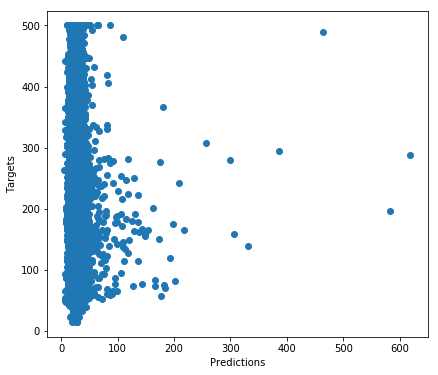

In [8]:
# We going to use pyplot's scatter() to create a scatter plot of predictions vs target
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])
plt.xlabel("Predictions")
plt.ylabel("Targets")

## Clip outliers

Let's clip max rooms per person to 3 and min to 0

In [22]:
california_housing_dataframe["clipped_rooms_per_person"] = california_housing_dataframe["rooms_per_person"].clip(0, 3)

Lets apply this function instead

Training model...
RMSE (on training data):
  period 00 : 235.06
  period 01 : 232.58
  period 02 : 230.11
  period 03 : 227.65
  period 04 : 225.20
  period 05 : 222.75
  period 06 : 220.31
  period 07 : 217.88
  period 08 : 215.46
  period 09 : 213.04
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,26.9,207.3
std,6.3,116.0
min,5.8,15.0
25%,22.6,119.4
50%,27.3,180.4
75%,31.2,265.0
max,39.0,500.0


Final RMSE (on training data): 213.04


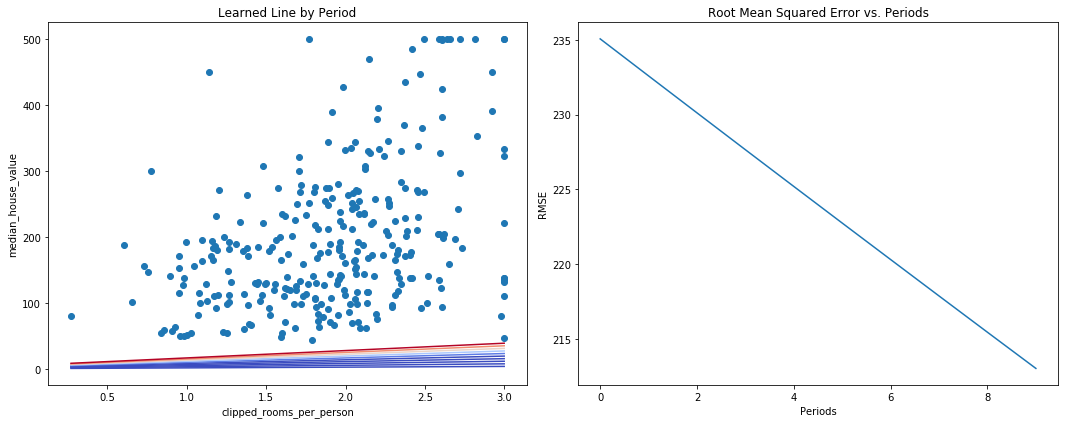

In [25]:
calibration_data_clipped = train_model_new(
    learning_rate = 0.005,
    steps = 500,
    batch_size = 5,
    input_feature = "clipped_rooms_per_person"
)

In [24]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data_clipped["predictions"], calibration_data_clipped["targets"])
plt.xlabel("Prediction")
plt.ylable("Targets")

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>